# Drone Detection - Baseline Model

In [ ]:
%pip install -r requirements.in

In [99]:
from typing import List, Dict, Tuple, Union
import os
import re
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score

# Local utils.py
import nbutils

sns.set_theme()

In [96]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

## Load Dataset

In [42]:
os.listdir("./data/drone-detection/drone-detection-new.v5-new-train.yolov8/train/labels")[:5]

['V_BIRD_03392_195_png.rf.9d971c3dc04a00cc892a2a76cdf986ea.txt',
 'V_AIRPLANE_0077_111_png.rf.c602106252445ad944d9609db95dc001.txt',
 'V_DRONE_056166_062_png.rf.64434b6dbc43420ee6914e5d0b216e25.txt',
 'V_HELICOPTER_017241_133_png.rf.14d0776b6bf84653773d3728cecf5d99.txt',
 'V_BIRD_00261_270_png.rf.5c496c5818dfb824f8baaf59fa9911c6.txt']

In [21]:
os.listdir("./data/drone-detection/drone-detection-new.v5-new-train.yolov8/train/images")[:5]

['V_AIRPLANE_05151_221_png.rf.21d8b8b16f0a7fb7875c0d1584ddbf92.jpg',
 'V_BIRD_03695_252_png.rf.7e3f49c841f7cf3859533521242e48ff.jpg',
 'V_DRONE_103213_296_png.rf.db33011e4446e972d708922853888aed.jpg',
 'V_DRONE_022132_051_png.rf.ac77e7ef522f554d820848d0a4ae631b.jpg',
 'V_BIRD_051110_276_png.rf.31dfc6416f67ab3de1288f181788db07.jpg']

In [58]:
base_path = "./data/drone-detection/drone-detection-new.v5-new-train.yolov8/train"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

df = nbutils.create_dataset(images_path, labels_path)

## Exploratory Data Analysis

In [ ]:
nbutils.view_df_summary(df)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997 entries, 0 to 8996
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_file    8997 non-null   object 
 1   label_file    8997 non-null   object 
 2   image_id      8997 non-null   object 
 3   class         8997 non-null   object 
 4   x_center      8997 non-null   float64
 5   y_center      8997 non-null   float64
 6   width         8997 non-null   float64
 7   height        8997 non-null   float64
 8   image_width   8997 non-null   int64  
 9   image_height  8997 non-null   int64  
 10  image_path    8997 non-null   object 
 11  label_path    8997 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 843.6+ KB


In [62]:
df.head()

,image_file,label_file,image_id,class,x_center,y_center,width,height,image_width,image_height,image_path,label_path
0,V_HELICOPTER_013237_222_png.rf.67ee88f10c1af6f...,V_HELICOPTER_013237_222_png.rf.67ee88f10c1af6f...,013237_222,HELICOPTER,0.561719,0.639062,0.032031,0.043750,640,640,./data/drone-detection/drone-detection-new.v5-...,./data/drone-detection/drone-detection-new.v5-...
1,V_DRONE_009119_221_png.rf.d577aad70873a29c97c2...,V_DRONE_009119_221_png.rf.d577aad70873a29c97c2...,009119_221,DRONE,0.524219,0.312500,0.037500,0.032031,640,640,./data/drone-detection/drone-detection-new.v5-...,./data/drone-detection/drone-detection-new.v5-...
2,V_DRONE_087197_027_png.rf.231f13db2fe70d87c56e...,V_DRONE_087197_027_png.rf.231f13db2fe70d87c56e...,087197_027,DRONE,0.619531,0.521875,0.092188,0.098437,640,640,./data/drone-detection/drone-detection-new.v5-...,./data/drone-detection/drone-detection-new.v5-...
3,V_DRONE_023133_005_png.rf.4829336ee822c17c31e7...,V_DRONE_023133_005_png.rf.4829336ee822c17c31e7...,023133_005,DRONE,0.634375,0.720313,0.081250,0.049219,640,640,./data/drone-detection/drone-detection-new.v5-...,./data/drone-detection/drone-detection-new.v5-...
4,V_DRONE_087197_234_png.rf.2478eedaa51e1d365f8c...,V_DRONE_087197_234_png.rf.2478eedaa51e1d365f8c...,087197_234,DRONE,0.688281,0.199219,0.083594,0.089844,640,640,./data/drone-detection/drone-detection-new.v5-...,./data/drone-detection/drone-detection-new.v5-...


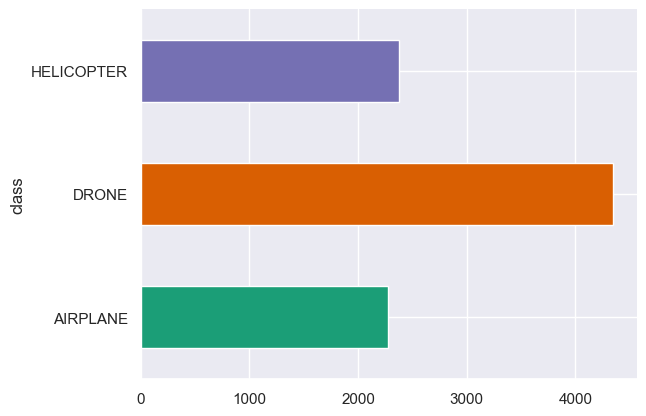

In [63]:
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

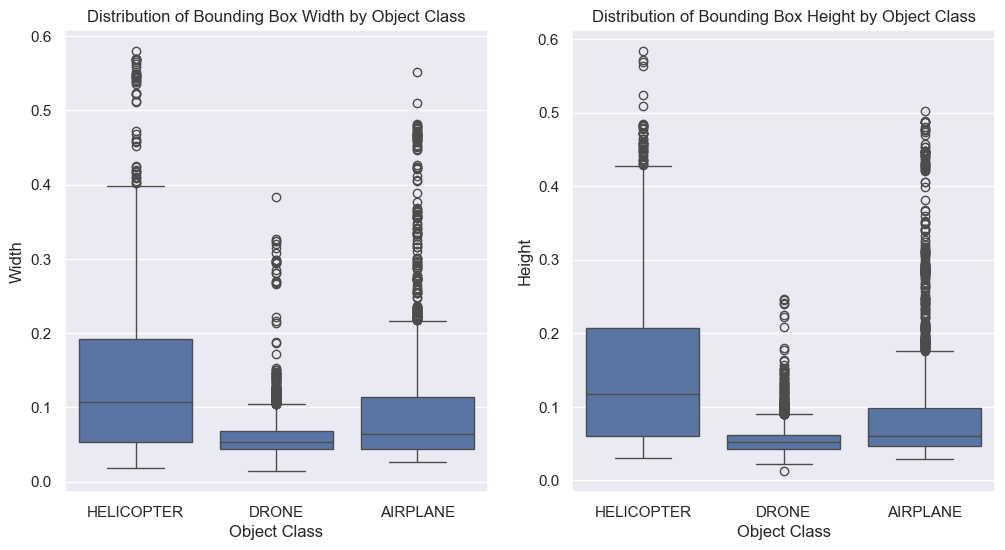

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='width', data=df)
plt.title('Distribution of Bounding Box Width by Object Class')
plt.xlabel('Object Class')
plt.ylabel('Width')

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='height', data=df)
plt.title('Distribution of Bounding Box Height by Object Class')
plt.xlabel('Object Class')
_ = plt.ylabel('Height')

## Dataset and Dataloader

In [91]:
class DroneDetectionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self.unique_images = self.df.groupby('image_path').agg({
            'x_center': list,
            'y_center': list,
            'width': list,
            'height': list,
            'class': list
        }).reset_index()

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, idx):
        row = self.unique_images.iloc[idx]

        image = Image.open(row['image_path'])
        if self.transform:
            image = self.transform(image)

        # Create a single box tensor
        boxes = torch.zeros((1, 5))  # Shape: (1, 5)
        boxes[:, 0] = -1  # Initialize with -1 for empty boxes

        # Only use the first detection for now
        if len(row['x_center']) > 0:
            class_name = row['class'][0]
            class_id = 0  # AIRPLANE
            if class_name == 'DRONE':
                class_id = 1
            elif class_name == 'HELICOPTER':
                class_id = 2

            boxes[0] = torch.tensor([
                float(class_id),
                float(row['x_center'][0]),
                float(row['y_center'][0]),
                float(row['width'][0]),
                float(row['height'][0])
            ])

        return image, boxes

## Detection Loss Function

In [92]:
class DetectionLoss(nn.Module):
    def __init__(self, class_weight=1.0, bbox_weight=1.0):
        super(DetectionLoss, self).__init__()
        self.class_weight = class_weight
        self.bbox_weight = bbox_weight

    def box_iou(self, pred_boxes, target_boxes):
        """Calculate IoU between predicted and target boxes"""
        # Convert center format to corners
        pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
        pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
        pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
        pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2

        target_x1 = target_boxes[:, 0] - target_boxes[:, 2] / 2
        target_y1 = target_boxes[:, 1] - target_boxes[:, 3] / 2
        target_x2 = target_boxes[:, 0] + target_boxes[:, 2] / 2
        target_y2 = target_boxes[:, 1] + target_boxes[:, 3] / 2

        # Calculate intersection area
        x1 = torch.max(pred_x1, target_x1)
        y1 = torch.max(pred_y1, target_y1)
        x2 = torch.min(pred_x2, target_x2)
        y2 = torch.min(pred_y2, target_y2)

        intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

        # Calculate union area
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
        union = pred_area + target_area - intersection

        return intersection / (union + 1e-6)

    def forward(self, pred_scores, pred_boxes, target_boxes):
        """
        Args:
            pred_scores: (batch_size, num_boxes, num_classes)
            pred_boxes: (batch_size, num_boxes, 4)
            target_boxes: (batch_size, num_boxes, 5)
        """
        device = pred_scores.device
        batch_size = pred_scores.size(0)

        # Ensure target_boxes has the correct shape
        if len(target_boxes.shape) == 2:
            target_boxes = target_boxes.unsqueeze(1)  # Add num_boxes dimension

        # Create mask for valid boxes (where class_id != -1)
        valid_mask = (target_boxes[..., 0] != -1)

        # Classification loss (only for valid boxes)
        target_classes = target_boxes[..., 0].long()

        # Reshape pred_scores to match expected input shape for cross_entropy
        pred_scores_reshaped = pred_scores.view(-1, pred_scores.size(-1))
        target_classes_reshaped = target_classes.view(-1)

        class_loss = F.cross_entropy(
            pred_scores_reshaped,
            target_classes_reshaped,
            reduction='none',
            ignore_index=-1
        ).view(batch_size, -1)

        class_loss = (class_loss * valid_mask.float()).sum() / (valid_mask.sum().float() + 1e-6)

        # Bounding box regression loss (only for valid boxes)
        valid_mask_expanded = valid_mask.unsqueeze(-1).expand(-1, -1, 4)
        pred_coords = pred_boxes[valid_mask_expanded].view(-1, 4)
        target_coords = target_boxes[..., 1:][valid_mask_expanded].view(-1, 4)

        if len(pred_coords) > 0:
            # Calculate IoU loss
            iou_loss = 1 - self.box_iou(pred_coords, target_coords)
            bbox_loss = iou_loss.mean()
        else:
            bbox_loss = torch.tensor(0.0).to(device)

        # Combine losses
        total_loss = self.class_weight * class_loss + self.bbox_weight * bbox_loss

        return total_loss, class_loss, bbox_loss

## Model Training

In [93]:
class MultiObjectAerialDetector(nn.Module):
    def __init__(self, num_classes=3, num_boxes=1):
        super(MultiObjectAerialDetector, self).__init__()
        self.num_boxes = num_boxes

        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Multi-box detection head
        self.detection_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_boxes * (num_classes + 4))  # class_scores + bbox coords per box
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        detections = self.detection_head(features)
        batch_size = detections.size(0)

        # Reshape output to (batch_size, num_boxes, num_classes + 4)
        detections = detections.view(batch_size, self.num_boxes, -1)

        # Split into class scores and bbox coordinates
        class_scores = detections[..., :3]  # First 3 elements are class scores
        bbox_coords = detections[..., 3:]   # Remaining 4 elements are bbox coordinates

        # Apply sigmoid to bbox coordinates to constrain them between 0 and 1
        bbox_coords = torch.sigmoid(bbox_coords)

        return class_scores, bbox_coords

In [94]:
def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    model = model.to(device)
    criterion = DetectionLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for images, boxes in pbar:
            images = images.to(device)
            boxes = boxes.to(device)

            # Forward pass
            pred_scores, pred_boxes = model(images)

            # Calculate loss
            loss, class_loss, bbox_loss = criterion(pred_scores, pred_boxes, boxes)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            pbar.set_postfix({
                'loss': f"{train_loss/(pbar.n+1):.4f}",
                'class_loss': f"{class_loss.item():.4f}",
                'bbox_loss': f"{bbox_loss.item():.4f}"
            })

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, boxes in val_loader:
                images = images.to(device)
                boxes = boxes.to(device)

                pred_scores, pred_boxes = model(images)
                loss, _, _ = criterion(pred_scores, pred_boxes, boxes)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_aerial_detector.pth')

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Best Val Loss: {best_val_loss:.4f}')


In [95]:
model = MultiObjectAerialDetector(num_classes=3, num_boxes=1)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

dataset = DroneDetectionDataset(df, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train model
train_model(model, train_loader, val_loader, 1, device="mps")

Epoch 1/1: 100%|██████████| 441/441 [01:07<00:00,  6.53it/s, loss=1.4596, class_loss=0.6358, bbox_loss=0.9913]



Epoch 1/1:
Train Loss: 1.4596
Val Loss: 1.3154
Best Val Loss: 1.3154


In [ ]:
sample_image, sample_boxes = dataset[0]

sample_image = sample_image.unsqueeze(0).to(device)
sample_boxes = sample_boxes.to(device)

model.eval()

with torch.no_grad():
    pred_scores, pred_boxes = model(sample_image)

print("Predicted scores:", pred_scores)
print("Predicted boxes:", pred_boxes)

predicted_class = torch.argmax(pred_scores[0, 0, :])
print("Predicted class:", predicted_class)


Predicted scores: tensor([[[ 0.1978, -1.0913,  0.2445]]], device='mps:0')
Predicted boxes: tensor([[[0.4878, 0.4917, 0.4402, 0.4402]]], device='mps:0')
Predicted class: tensor(2, device='mps:0')


## Metrics

In [ ]:
metrics = nbutils.evaluate_model(model, dataset, num_samples=10)
metrics